# Initialisation

In [1]:
""" Importing key libraries and modules """
import time
from datetime import datetime, timedelta

import numpy as np
import scipy.constants as con
import math
from uncertainties.umath import * # for mathematical operations, e.g. unumpy.sin(x)

import speasy as spz
import SerPyShock as SP
from data_functions import *
from calc_functions import *
from rankine_functions import * 

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib widget

## Input Satellite Data

These are the only parameters that need to be changed in the program:

- time_shock: the date and time of the shock we are looking at, (as detected by the spacecraft) in Universal Time
- name_spacecraft: the satellite we are looking at, (e.g. WIND in the solar wind)
- method: the method used to calculate the normal vector of the shock, (e.g. MX3)
- location: the location purely for printing purposes

In [2]:
""" Input date and time of the shock, and the period of analysis before and after """

# Date and time of the shock
time_shock = pd.to_datetime("2015-05-06 01:40:00")

# Name of the spacecraft, i.e. THEMIS cluster, WIND
name_spacecraft = "THE"

# The method to be used in the analysis
method = "MX3"

# Where the shock is being located - purely for printing and figure purposes
location = "Solar Wind"

## Averaging Windows

These parameters are taken directly from Trotta (2022). "The ipshocks.fi catalogue uses windows of 8 minutes upstream and 8 minutes downstream of the shock, and they exclude 1 minute upstream and 2 minutes downstream of the shock."

In [3]:
""" Defining the variables for multiple averaging windows """

# Minutes observed before and after the shock
time_obs = 15
start_date = time_shock - timedelta(minutes = time_obs)
end_date = time_shock + timedelta(minutes = time_obs)

# Defining where the "upstream" and "downstream" regions are
# These are used to obtain the "upstream" and "downstream" quantity values, e.g. density-upstream
start_time_up  = time_shock  - timedelta(minutes = 9) # Largest upstream window start time
end_time_up = time_shock  - timedelta(minutes = 1)    # Largest upstream window end time
start_time_dw  = time_shock  + timedelta(minutes = 2) # Largest downstream window start time
end_time_dw = time_shock  + timedelta(minutes = 10)   # Largest downstream window end time

# Select minimum and maximum durations of the upstream and downstream windows for the systematic analysis
min_up_dur = timedelta(minutes = 2) # Duration of the smallest upstream window (time will span end_time_up - min_dur_up --> end_time_up + min_dur_up)
max_up_dur = end_time_up - start_time_up # Duration of the largest upstream window (do not edit)
min_dw_dur =  timedelta(minutes = 2) # Duration of the smallest downstream window (time will span start_time_down --> start_time_down + min_dur_down)
max_dw_dur = end_time_dw - start_time_dw # Duration of the largest downstream window (do not edit)
#Select the cadence by which the window lengths are increased (should be larger than the instrument plasma cadence)
tcad =  timedelta(seconds=20)

# Define the list of time up and down for our averaging range
window_up = (start_time_up, end_time_up)
window_dw = (start_time_dw, end_time_dw)

# Define variables used to plot the minimum and maximum windows
up_windows = (end_time_up - min_up_dur, end_time_up - max_up_dur)
dw_windows = (start_time_dw + min_dw_dur, start_time_dw + max_dw_dur)

# Main Program

## Retrieving Data

Retrieves the plasma parameters from the appropiate satellite and location using the Speasy routines.

In [4]:
if __name__ == "__main__":
    print("Analysing a shock detected by",name_spacecraft,"in the",location,"using the",method,"method\n")
    # Find the coordinates of the satellite
    satellite_info(name_spacecraft, time_shock)
    print()
    
    # Retrives the plasma parameters
    time_mag, B, B_unit = get_Bfield(name_spacecraft, start_date, end_date)
    B_up, B_dw = filter_up_dw(time_mag, B, window_up, window_dw)
    
    time_vel, V, V_unit = get_velocity(name_spacecraft, start_date, end_date)
    V_up, V_dw = filter_up_dw(time_vel, V, window_up, window_dw)
    
    time_rho, rho, rho_unit = get_density(name_spacecraft, start_date, end_date)
    rho_up, rho_dw = filter_up_dw(time_rho, rho, window_up, window_dw, 1)
    
    time_pres, pres, pres_unit = get_pressure(name_spacecraft, start_date, end_date, rho)
    p_up, p_dw = filter_up_dw(time_pres, pres, window_up, window_dw, 1)
    
    print("Upstream Parameters:\n")
    print_avg(B_up, "Magnetic Field", B_unit)
    print_avg(V_up, "Bulk Flow", V_unit)
    print_avg(rho_up, "Number Density", rho_unit, 1)
    print_avg(p_up*10**9, "Pressure", "nPa", 1)
    print()
    
    print("Downstream Parameters:\n")
    print_avg(B_dw, "Magnetic Field", B_unit)
    print_avg(V_dw, "Bulk Flow", V_unit)
    print_avg(rho_dw, "Number Density", rho_unit, 1)
    print_avg(p_dw*10**9, "Pressure", "nPa", 1)
    print()

Analysing a shock detected by THE in the Solar Wind using the MX3 method

The time is: 2015-05-06 01:40:00
The satellite coordinates are: [11.5783   1.98567 -2.11391]

Upstream Parameters:

Magnetic Field: [-1.6, 32.0, 24.4] ± [1.3, 3.4, 3.4] nT
Magnitude: 40.3±3.4 nT
Bulk Flow: [-20.0, 49.0, -35.0] ± [8.0, 17.0, 14.0] km/s
Magnitude: 64±16 km/s
Number Density: 22.7±2.7 cm-3
Pressure: 0.55±0.08 nPa

Downstream Parameters:

Magnetic Field: [-5.3, 39.0, 8.0] ± [2.6, 5.0, 9.0] nT
Magnitude: 40±5 nT
Bulk Flow: [-153.0, 33.0, -27.0] ± [33.0, 13.0, 23.0] km/s
Magnitude: 159±32 km/s
Number Density: 49±9 cm-3
Pressure: 1.8±0.6 nPa



## Shock Velocity

Calculates the speed of the shock using Trotta's multiple averaging windows method.

In [5]:
if __name__ == "__main__":
    print("Using Trotta's multiple averaging windows method and code\n")
    
    # Variable defined for the multiple averaging windows
    datetime_objects = pd.to_datetime(time_mag)
    freq = "ns"
    datetime_index = pd.DatetimeIndex(datetime_objects).floor(freq)
    
    # Extends/interpolates the data to match precision of B
    interp_V, ext_rho, ext_pres = extend_data(B, V, rho, pres)
    
    # Calculating the shock normal and speed, (and angle with the upstream magnetic field)
    avg_normal, avg_angle, avg_speed = SP_shock_speed(datetime_index, B, interp_V, ext_rho, time_shock, end_time_up, start_time_dw, min_up_dur, max_up_dur, min_dw_dur, max_dw_dur, tcad, method)
    print_data("Normal Vector in GSE", avg_normal)
    print_data("Angle", avg_angle, "degrees")
    print_data("Shock Speed", avg_speed, V_unit)

Using Trotta's multiple averaging windows method and code

Normal Vector in GSE: [-0.98, -0.121, 0.156] ± [0.005, 0.027, 0.023] 
Angle: 87.7±1.2 degrees
Shock Speed: 302±31 km/s


# Figures

## Shock Jump

This figure plots the data as seen in the frame of the spacecraft, (i.e. as the shock passes). We should see the characteristic "jump" for a shock. If we don't, then we aren't actually looking at a shock.

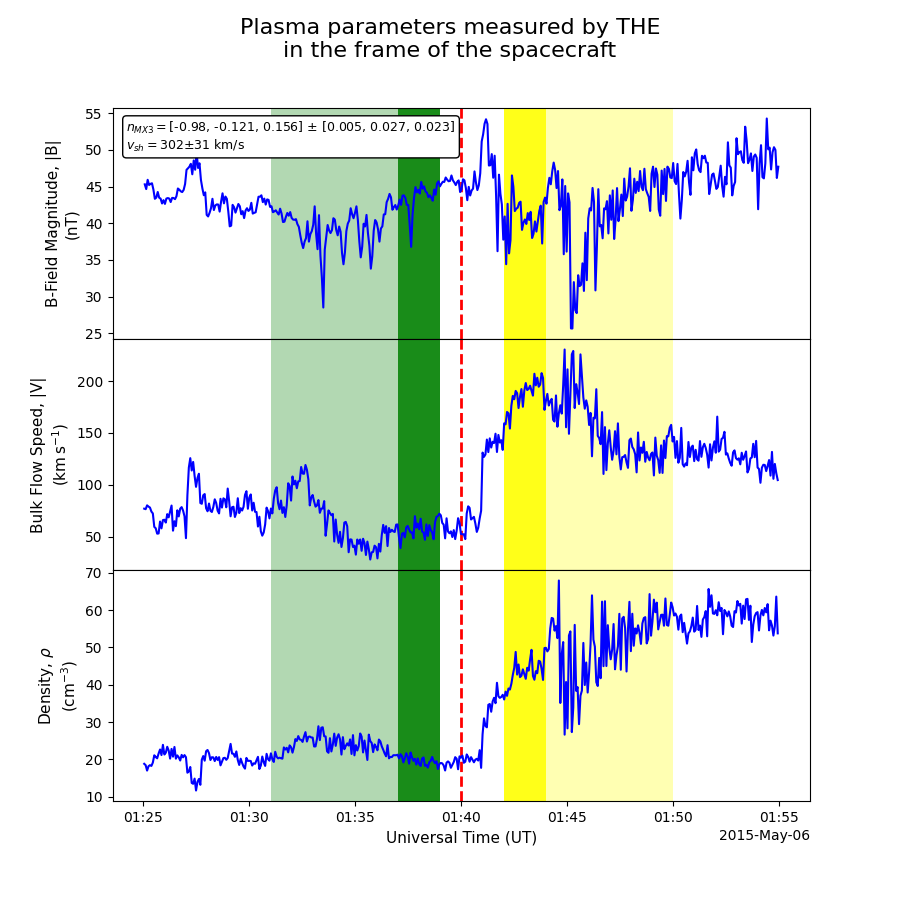

In [6]:
if __name__ == "__main__":
    # Figure parameters
    fig = plt.figure(figsize=(9, 9))
    gs = fig.add_gridspec(3, hspace=0)
    axes = gs.subplots(sharex=True, sharey=False)
    for axi in axes:
        plot_line(up_windows, dw_windows, end_time_up, start_time_dw, time_shock, ax=axi) # Plotting a vertical line for the shock

    axes[0].plot(time_mag, [magnitude(B_i) for B_i in B], color="blue", label = "|B|")
    axes[0].set_ylabel("B-Field Magnitude, |B|\n(nT)", fontsize = 11)

    axes[1].plot(time_vel, [magnitude(V_i) for V_i in V], color="blue", label = "|V|")
    axes[1].set_ylabel("Bulk Flow Speed, |V|\n"+r"($\mathrm{km\,s^{-1}}$)", fontsize = 11)

    axes[2].plot(time_rho, rho, color="blue", label = r"$\rho$")
    axes[2].set_ylabel("Density, "+r"$\rho$"+"\n"+r"($\mathrm{cm^{-3}}$)", fontsize = 11)
    
    # Figure information
    n_mean, n_err = vector_uarray(avg_normal)
    data_string = str(n_mean) + " ± " + str(n_err)
    normal_str = "\n".join((
        r"$n_{MX3}=$"+data_string,
        r"$v_{sh}=$"+"{:fP} ".format(avg_speed)+str(V_unit)))

    
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle="round", facecolor="white", alpha=1)

    # place a text box in upper left in axes coords
    axes[0].text(0.02, 0.95, normal_str, transform=axes[0].transAxes, fontsize=9, verticalalignment="top", bbox=props)
    
    # Sets the x-axis labels to be easy to read
    axes[-1].set_xlabel("Universal Time (UT)",fontsize = 11)
    locator = mdates.AutoDateLocator()
    axes[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    fig.suptitle(f"Plasma parameters measured by {name_spacecraft}\nin the frame of the spacecraft", fontsize = 16)
    
    #plt.close()

## RH Quantities

Calculates the average values of certain quantities that should be conserved upstream and downstream of the shock, as shown from the Rankine-Hugoniot equations. If the equations aren't valid, then the analysis to calculate the shock normal and velocity are equally invalid.

In [7]:
if __name__ == "__main__":
    print("Rankine-Hugoniot Analysis:\n")
    
    # Equation 1 - [B_n] = 0?
    RH_1_up, RH_1_dw = rankine_1(B_up, B_dw, avg_normal)
    RH_result(RH_1_up, RH_1_dw, B_unit)
    
    # Equation 2 - [rho*v_n] = 0?
    RH_2_up, RH_2_dw = rankine_2(rho_up, rho_dw, V_up, V_dw, avg_normal, avg_speed)
    RH_result(RH_2_up, RH_2_dw, rho_unit+V_unit)
    
    # Equation 3 - [B_n*V - v_n*B] = 0?
    RH_3_up, RH_3_dw = rankine_3(B_up, B_dw, V_up, V_dw, avg_normal, avg_speed)
    RH_result(RH_3_up, RH_3_dw, B_unit+V_unit)
    
    # Equation 4a - [rho*v_n^2+P+(B^2/2-B_n^2)/mu0] = 0?
    RH_4a_up, RH_4a_dw = rankine_4a(rho_up, V_up, B_up, p_up, rho_dw, V_dw, B_dw, p_dw, avg_normal, avg_speed)
    RH_result(RH_4a_up, RH_4a_dw, "nPa")
    
    # Equation 4b - [rho*v_n*V_t-(B_nB_t)/mu0] = 0?
    RH_4b_up, RH_4b_dw = rankine_4b(rho_up, rho_dw, V_up, V_dw, B_up, B_dw, avg_normal, avg_speed)
    RH_result(RH_4b_up, RH_4b_dw, "nPa")
    
    # Storing all the conserved quantities for plotting
    window_quantities = [(RH_1_up, RH_1_dw),
                         (RH_2_up, RH_2_dw),
                         (RH_3_up, RH_3_dw),
                         (RH_4a_up, RH_4a_dw),
                         (RH_4b_up, RH_4b_dw)]

Rankine-Hugoniot Analysis:


Quantity is conserved.
Upstream: 1.5±1.8 nT
Downstream: 1.7±3.2 nT
Difference: 0.2±3.4 nT
0.046417 sigma

Quantity is conserved.
Upstream: -6670±1067 cm-3km/s
Downstream: -7864±2614 cm-3km/s
Difference: 1194±2415 cm-3km/s
0.49426 sigma

Quantity is not conserved.
Upstream: [-50.0, 9526.0, 7039.0] ± [345.0, 1410.0, 1248.0] nTkm/s
Downstream: [-609.0, 6410.0, 1131.0] ± [328.0, 1947.0, 1438.0] nTkm/s
Difference: [559.0, 3116.0, 5908.0] ± [374.0, 1827.0, 1804.0] nTkm/s

Quantity is conserved.
Upstream: 4.5±0.8 nPa
Downstream: 4.6±1.4 nPa
Difference: 0.1±1.2 nPa
0.092835 sigma

Quantity is conserved.
Upstream: [0.13, -0.6, 0.38] ± [0.04, 0.22, 0.17] nPa
Downstream: [0.19, -0.71, 0.6] ± [0.08, 0.28, 0.4] nPa
Difference: [0.05, 0.11, 0.3] ± [0.08, 0.33, 0.4] nPa


In [ ]:
# The following code is quite slow, which is why I've put this line break in
answer = input("Do you want to produce the RH figure?\n(Type 'no' if you want to stop the program here)\n")
if answer == "no": 
    raise KeyboardInterrupt

In [ ]:
if __name__ == "__main__":
    RH_quantities = rankine_analysis(B, interp_V, ext_rho, ext_pres, avg_normal, avg_speed)

In [ ]:
if __name__ == "__main__":
    # Labels used for plotting a figure
    units = [B_unit,rho_unit+V_unit,B_unit+V_unit,"nPa","nPa"]
    legend_labels = [(r"$B_{nu}=$",r"$B_{nd}=$"),
                  (r"$(\rho V_{n})_{u}=$",r"$(\rho V_{n})_{d}=$"),
                  (r"$(E_{t})_{u}=$",r"$(E_{t})_{d}=$"),
                  (r"$(E_{t})_{u}=$",r"$(E_{t})_{d}=$"),
                  (r"$(E_{t})_{u}=$",r"$(E_{t})_{d}=$")]
    y_axis_labels = ["B-Field, "+r"$B_n$"+"\n(nT)",
                     "Mass Flow\n"+"$(\mathrm{km\,s^{-1}\,cm^{-3}})$",
                     "Tangential E-field, "+r"$E_{t}$"+"\n"+"$(\mathrm{nT\,m\,s^{-1}})$",
                     "Thermal Pressure, "+r"$p_{t,y}$"+"\nnPa",
                     "Ram Pressure, "+r"$p_{t,z}$"+"\nnPa"]
    
    # Figure parameters
    fig = plt.figure(figsize=(9,2.5*len(RH_quantities)))
    gs = fig.add_gridspec(len(RH_quantities), hspace=0)
    axes = gs.subplots(sharex=True, sharey=False)
    for axi in axes:
        plot_line(up_windows, dw_windows, end_time_up, start_time_dw, time_shock, ax=axi)
    
    # Looping through each Rankine-Hugoniot quantity to plot
    for i in range(len(RH_quantities)):
        # The plotted data, (i.e. the result of the calculation of the coninuous data)
        qty = RH_quantities[i]
        (upstream, downstream) = window_quantities[i] # The average upstream and downstream values
        
        # If we're looking at a vector, we'll plot it's magnitude for simplicity
        if isinstance(upstream, (list,tuple,np.ndarray)):
            axes[i].plot(time_mag, magnitude(nom_vals(RH_quantities[i])), color="blue")
            upstream = magnitude(upstream) ; downstream = magnitude(downstream)
        else:
            axes[i].plot(time_mag, nom_vals(qty), color="blue")
        label_up, label_dw = legend_labels[i][0]+"{:fP}".format(upstream), legend_labels[i][0]+"{:fP}".format(downstream)
        
        # Plotting the average values
        axes[i].hlines(upstream.n, window_up[0], window_up[1], color="red", label=label_up, ls=":", lw=2)
        axes[i].hlines(downstream.n, window_dw[0], window_dw[1], color="red", label=label_dw, ls=":", lw=2)
        axes[i].errorbar(end_time_up-max_up_dur/2, upstream.n, upstream.s, color="red", capsize=4)
        axes[i].errorbar(start_time_dw+max_dw_dur/2, downstream.n, downstream.s, color="red", capsize=4)
        
        axes[i].set_ylabel(y_axis_labels[i], fontsize = 11)
        axes[i].legend()
        
    # Sets the x-axis labels to be easy to read
    axes[-1].set_xlabel("Universal Time (UT)",fontsize = 11)
    locator = mdates.AutoDateLocator()
    axes[-1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

    fig.suptitle(f"Plasma parameters measured by {name_spacecraft}\nin the frame of the shock", fontsize = 16)
    
    #plt.close()